In [2]:
from keras.models import load_model, Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from module.dataset import AirbusDataset
from module.transform import normalize_rescale_blur, normalize_transform, normalize_rescale, means, stds
from module.dice import dice_coeff, dice_loss

# Process

We have 3 models of different size with different preprocessing procedures

We will roughly evaluate them on validation data (images with ships only) and a part of the whole dataset. 

Will also visualize some results.

For every model:
    - first notebook cell lods the model
    - second evaluates on validation data
    - third evaluates on all data

# Important

When we are testing models we already know their preprocessing procedures and we simply provide them to the dataset object at creation. Preprocessing algorithms used are in `transform.py`.

In [3]:
# we will analyze validation data results (all contain ships) and total data separately
ships = "./jsons/train_data_ships.json"
total = "./jsons/train_data_v2.json"

In [4]:
def dice_and_equal(model: Model, dataset: AirbusDataset, idx: list, w=1) -> (list, list):
    """
    Returns:
    for all batches of images of size w at indexes in idx:
        - dice coefs 
        - average precentages of pixels that coincide with the predicted mask (mask = prediction > 0.5)
    """
    dice_cf = []
    equal_ls = []
    for i in idx:
        image,mask = dataset[list(range(i,i+w))].values()
        prediction = model.predict(image)
        dice_cf.append(dice_coeff(tf.constant(mask, tf.float32), prediction))
        equal_ls.append(np.mean(mask == (prediction > 0.5))) # mask = prediction > 0.5
    return dice_cf, equal_ls

In [5]:
def visualize(idx: list, model: Model):
    """
    Visualizes:
    for every image at indexes in idx:
        
    """
    fig,axs = plt.subplots(nrows=len(idx), ncols=4, figsize=(12,len(idx)*4))
    image,mask = dataset[idx].values()
    prediction = model.predict(image)
    for j,(img,m,p,ax) in enumerate(zip(image,mask,prediction,axs)):
        ax[0].imshow(np.array(img*stds + means, dtype=np.uint8))
        ax[1].imshow(m)
        ax[2].imshow(p)
        ax[3].imshow(p >= 0.5)
        ax[0].set_title(f"{dataset.images[j]}")
        ax[1].set_title("mask")
        ax[2].set_title("prediction")
        ax[3].set_title("> 0.5")
    plt.show()

In [12]:
# indexes to evaluate validation data at
val_eval_idx = list(range(len(dataset)//2, len(dataset), 2000))
# indexes to visualize validation data at
vis_val_idx = list(range(21000, 40000, 1800))
# indexes to evaluate training data at
all_eval_idx = list(range(21000, 40000, 1800))
# indexes to visualize training data at
vis_all_idx = list(range(50000, 80000, 4000))

## ModelN - nano

accepts images `256x256x3`
preprocessing: normalize + resize + blur (median blur)

In [30]:
# load model, define transform
modeln = load_model("./models/ModelN.h5", custom_objects={"dice_loss": dice_loss})
transform = lambda images,masks: normalize_rescale_blur(images,masks,256,256)


dice loss 0.510353684425354
threshold equal 0.9966097745028407


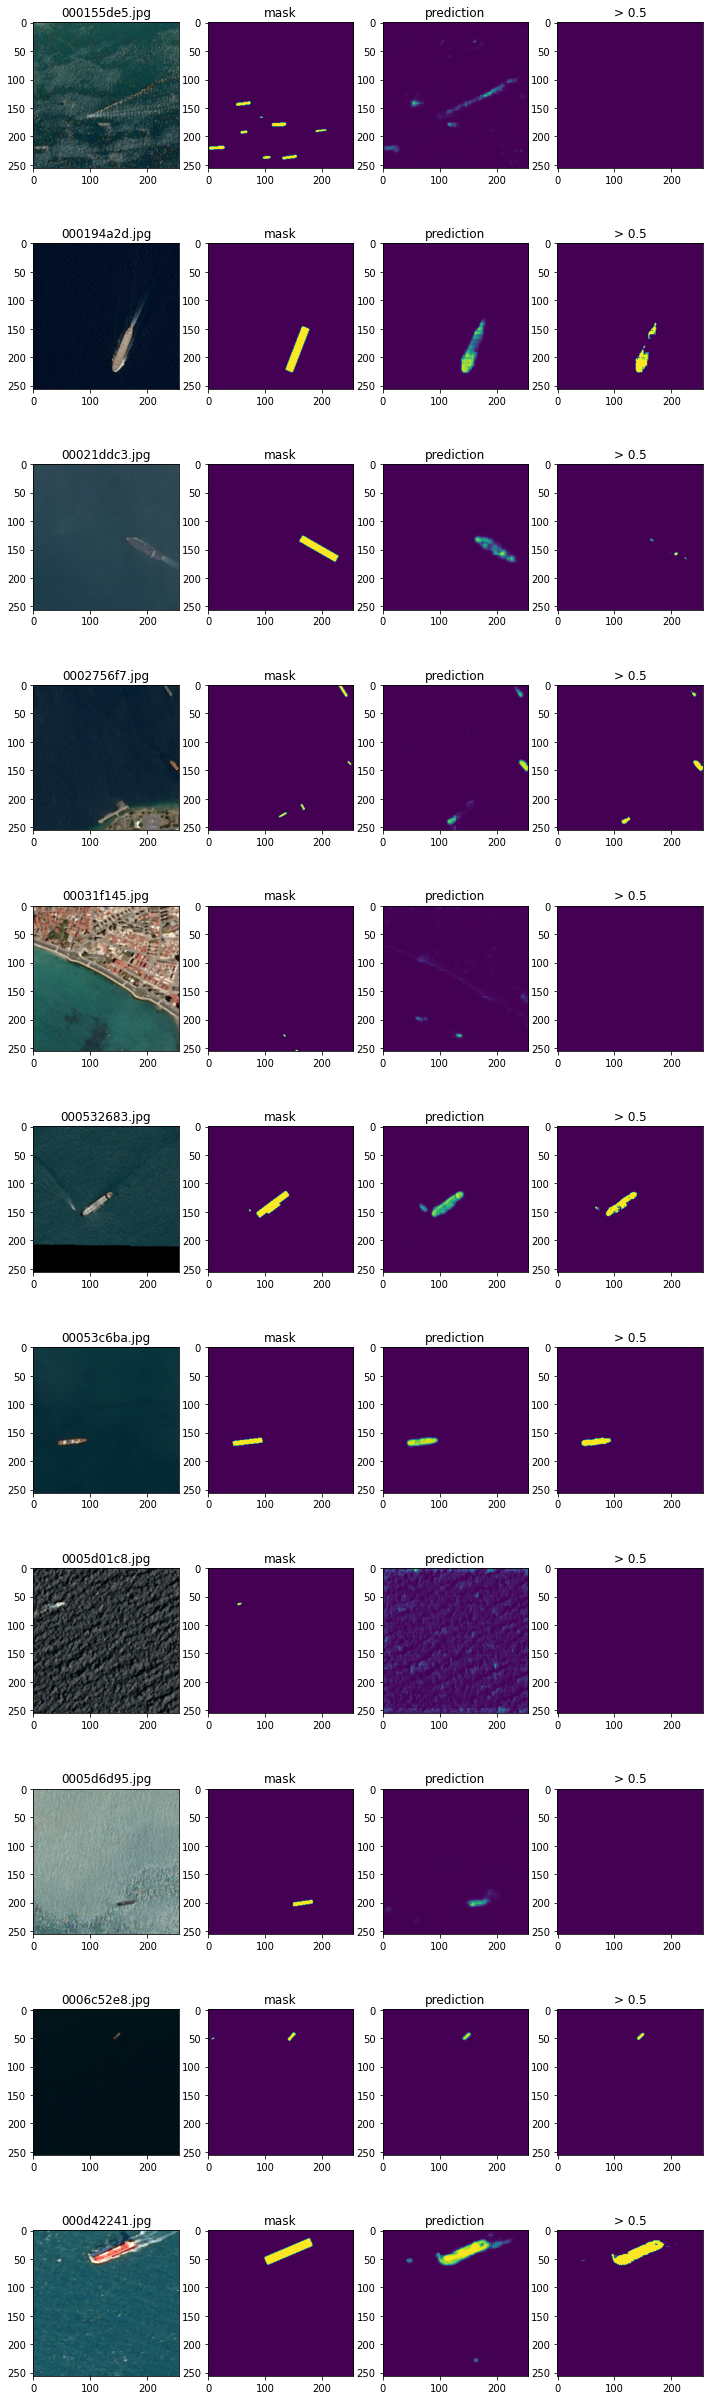

In [31]:
# validation data results
dataset = AirbusDataset(ships, transform=transform)
dice_ls, equal_ls = dice_and_equal(modeln, dataset, val_eval_idx, 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_val_idx, modeln)


dice loss 0.9708026349544525
threshold equal 0.9986713756214488


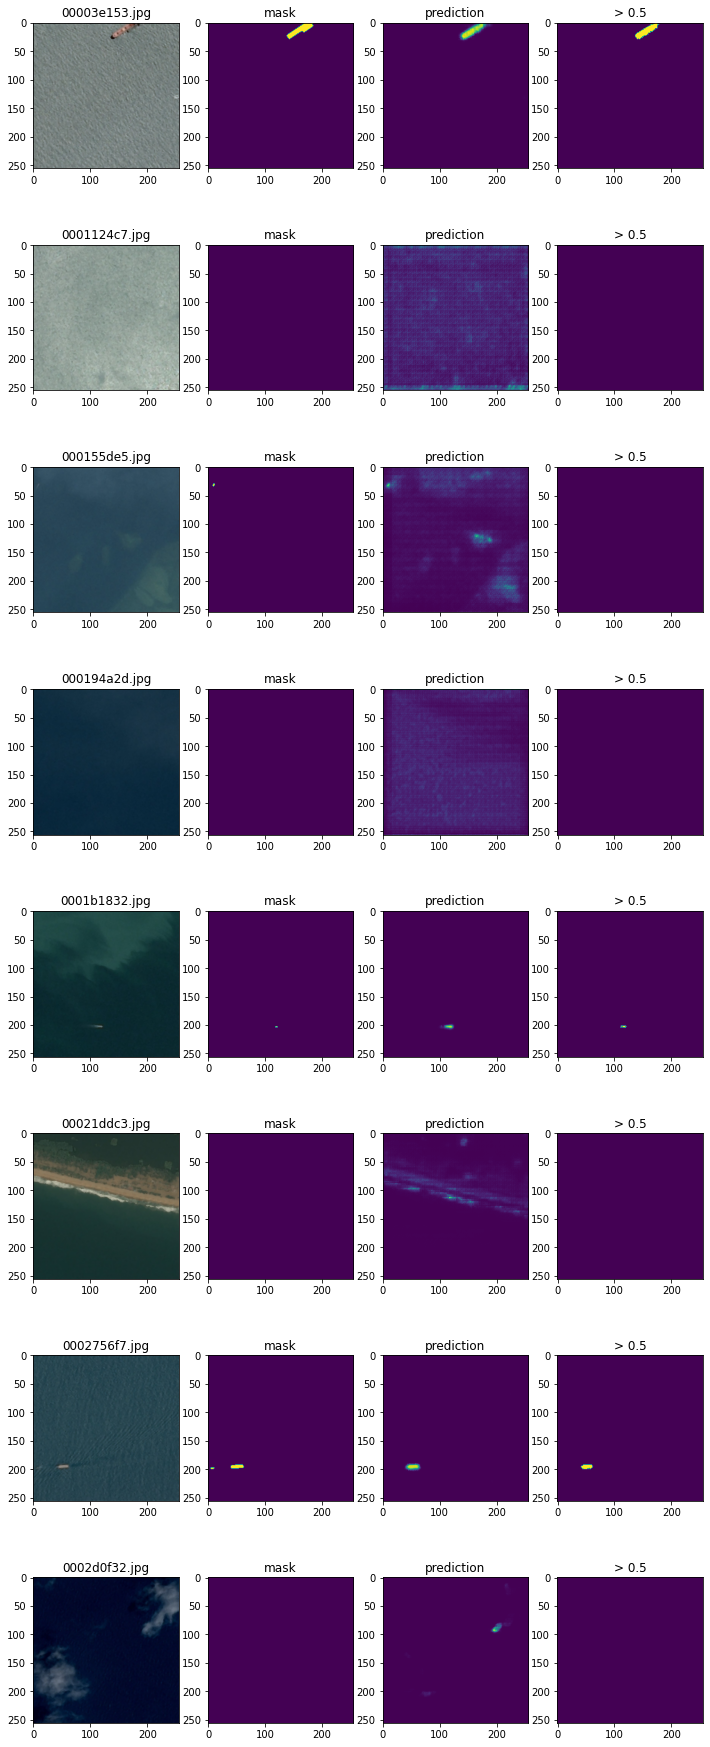

In [32]:
# total data results
dataset = AirbusDataset(total, transform=transform)
dice_ls, equal_ls = dice_and_equal(modeln, dataset, all_eval_idx, 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_all_idx, modeln)

# ModelS - small

accepts images `348x348x3`
preprocessing: normalize + rescale + blur

In [16]:
models = load_model("./models/ModelS.h5", custom_objects={"dice_loss": dice_loss})


dice loss 0.4993543028831482
threshold equal 0.9964826487531565


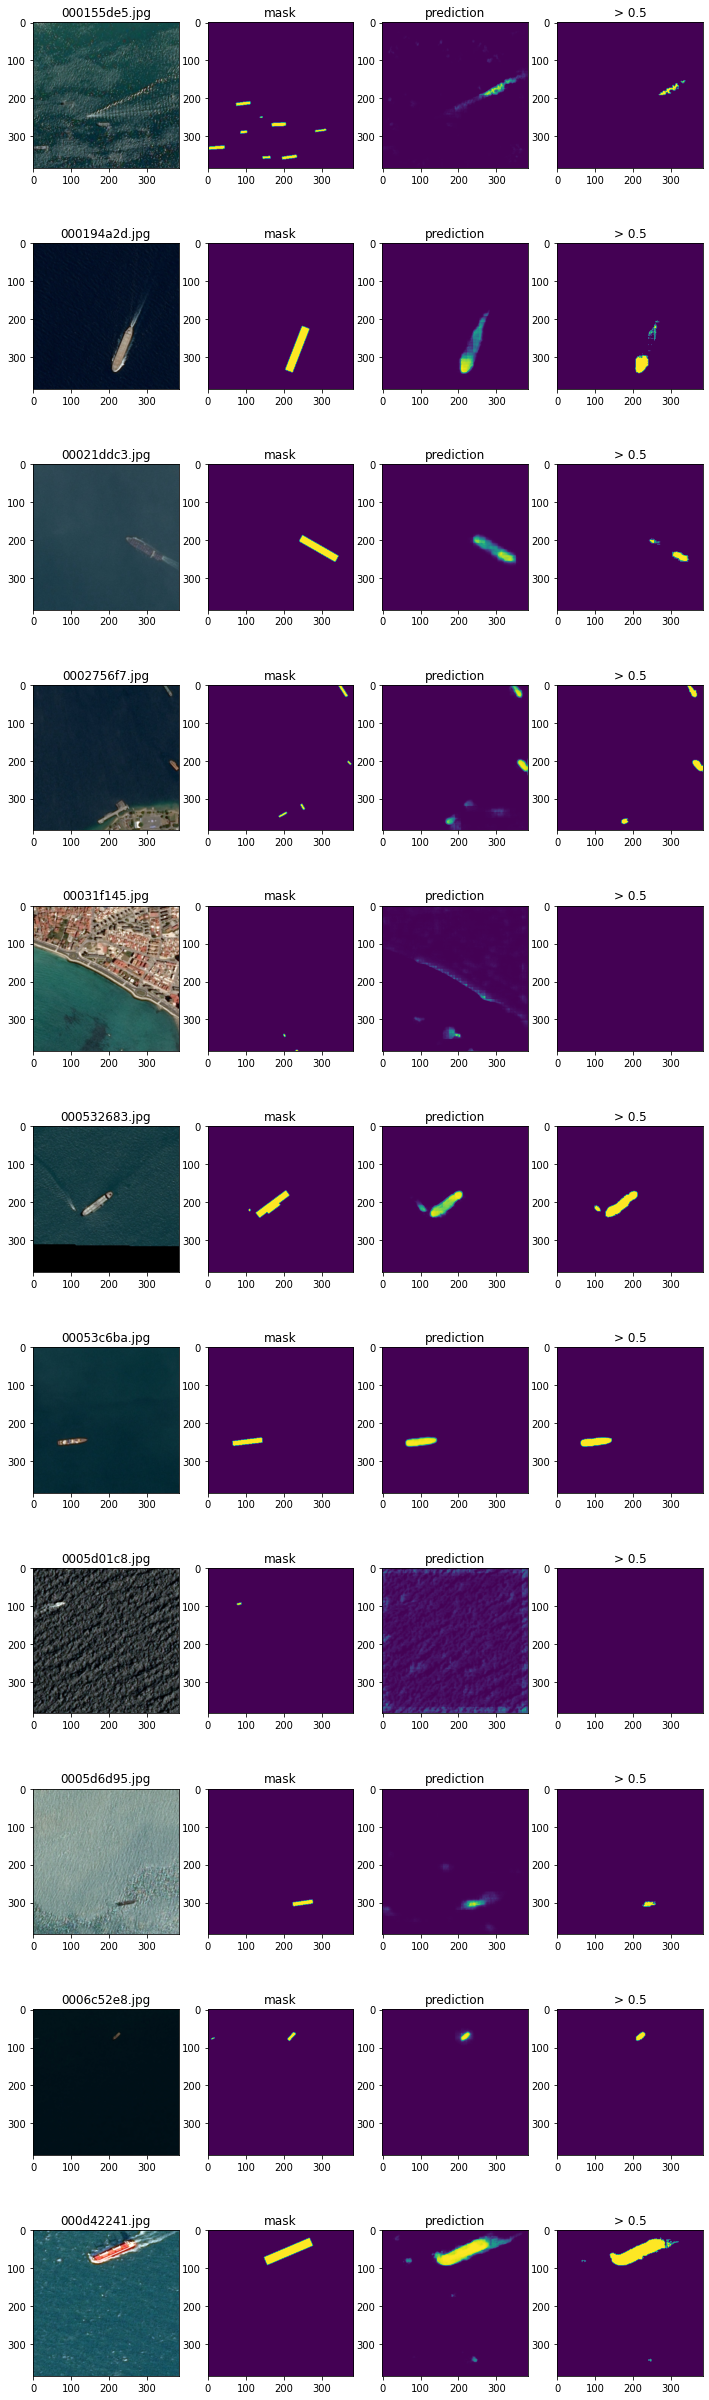

In [18]:
dataset = AirbusDataset(ships, transform=normalize_rescale_blur) # for validataion data analysis
dice_ls, equal_ls = dice_and_equal(models, dataset, val_eval_idx, 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_val_idx, models)


dice loss 0.85957932472229
threshold equal 0.9992833324986646


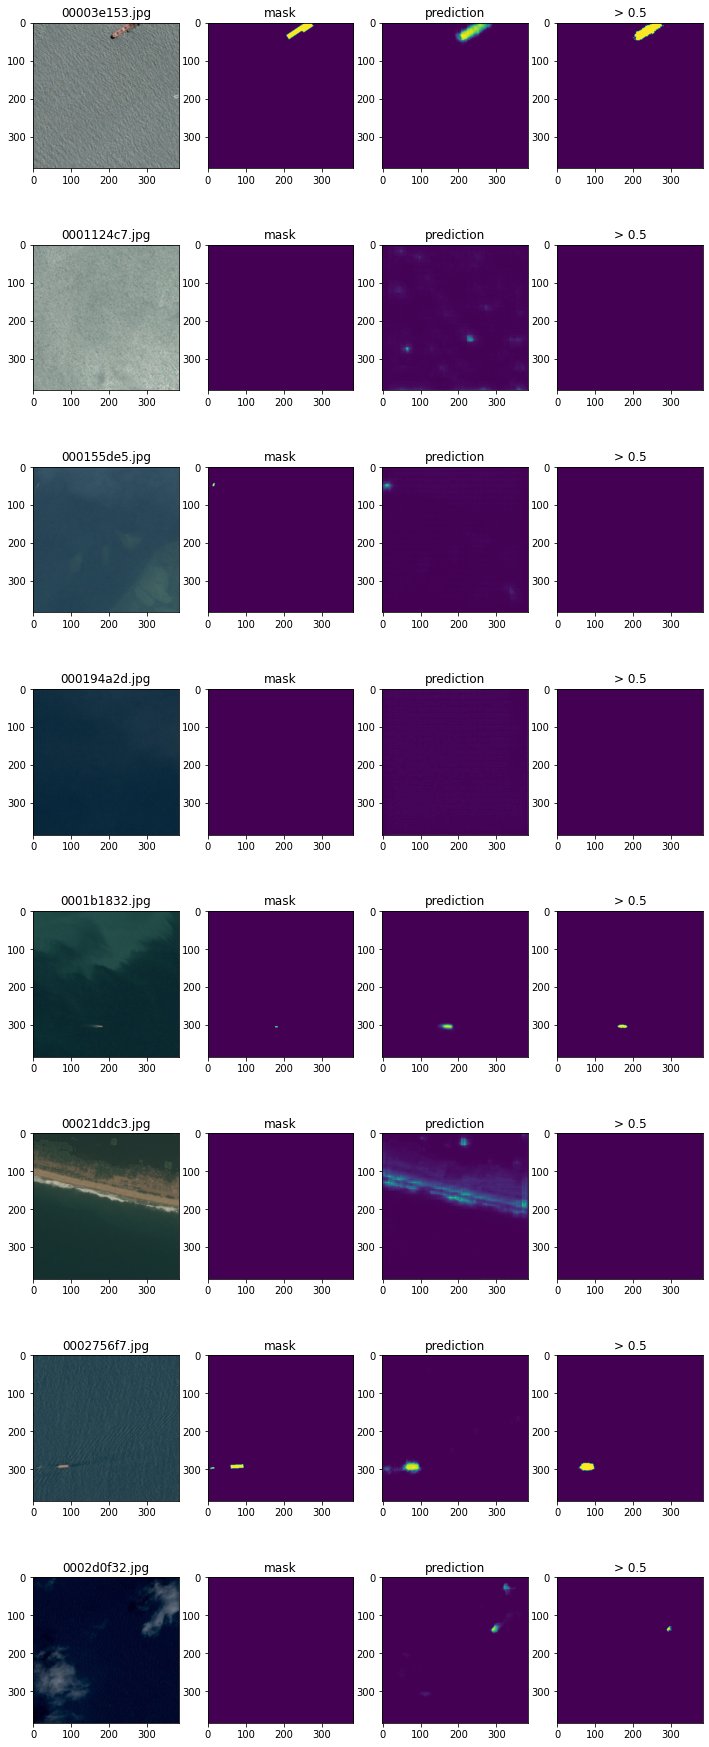

In [19]:
# total data results
dataset = AirbusDataset(total, transform=normalize_rescale_blur)
dice_ls, equal_ls = dice_and_equal(models, dataset, list(range(len(dataset)//2, len(dataset), 8000)), 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_all_idx, models)

# ModelB - big

accepts images of original size
preprocessing: normalization only

In [21]:
modelb = load_model("./models/ModelB.h5", custom_objects={"dice_loss": dice_loss})


dice loss 0.7546520829200745
threshold equal 0.995508490668403


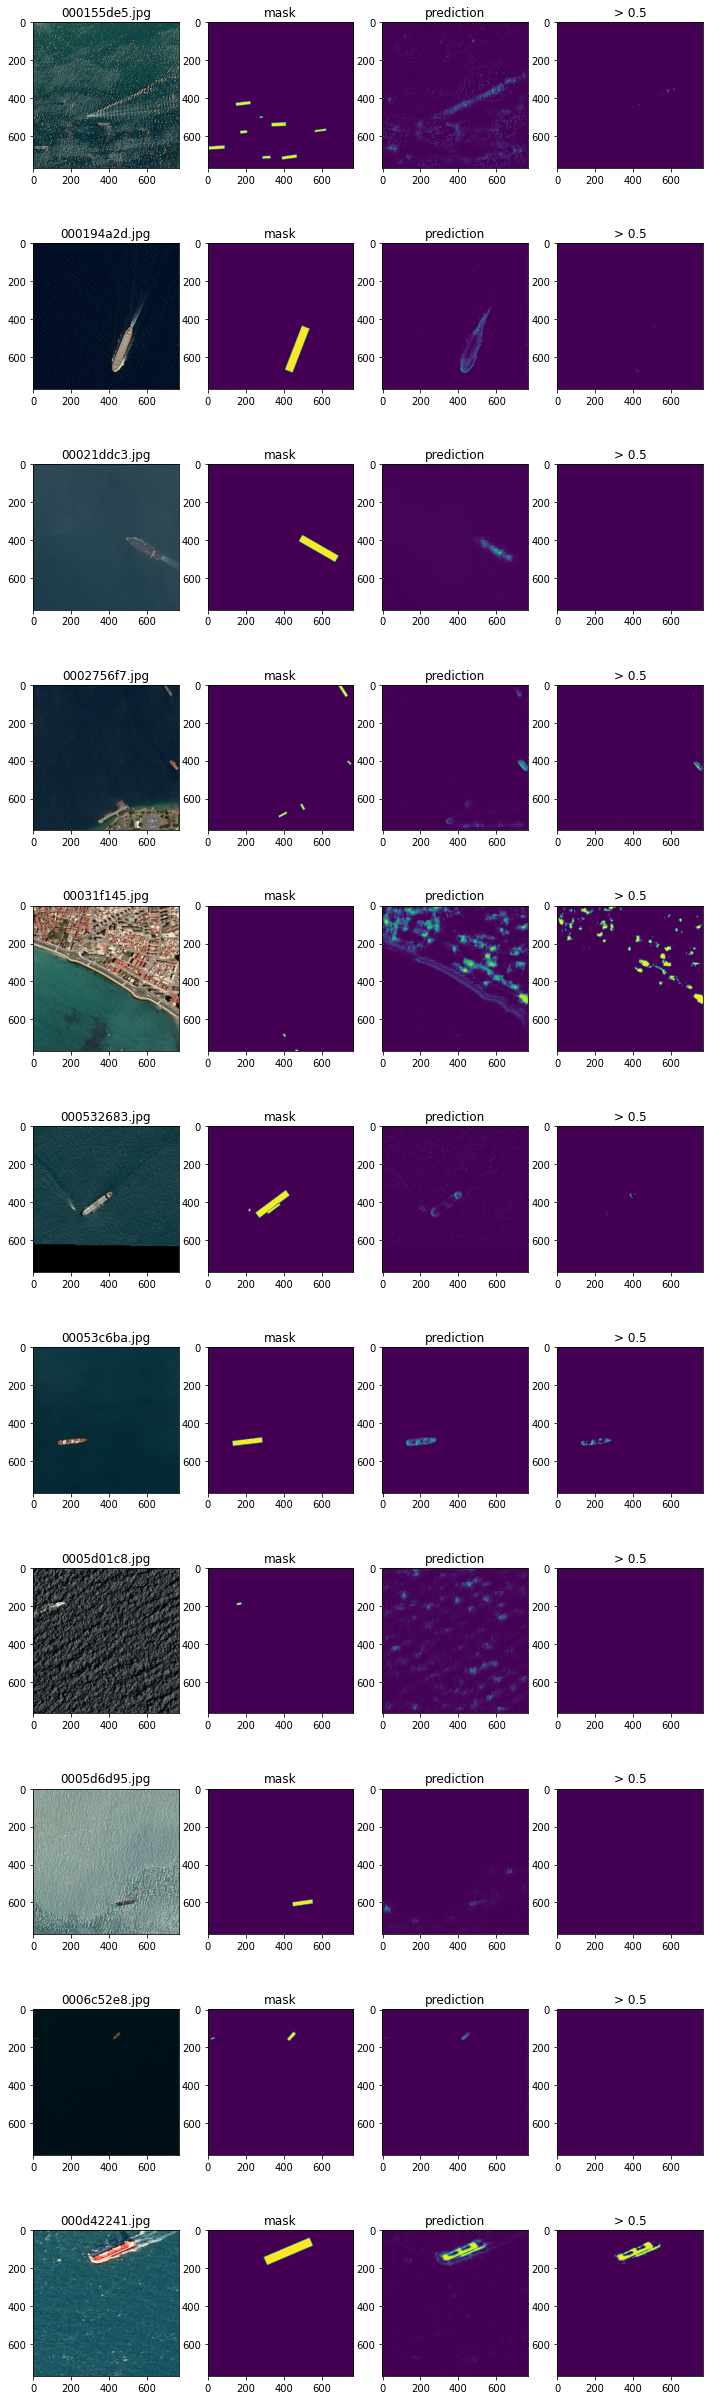

In [22]:
# valiation data results
dataset = AirbusDataset(ships, transform=normalize_transform)
dice_ls, equal_ls = dice_and_equal(modelb, dataset, val_eval_idx, 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_val_idx, modelb)


dice loss 0.9594510830938816
threshold equal 0.99888740308357


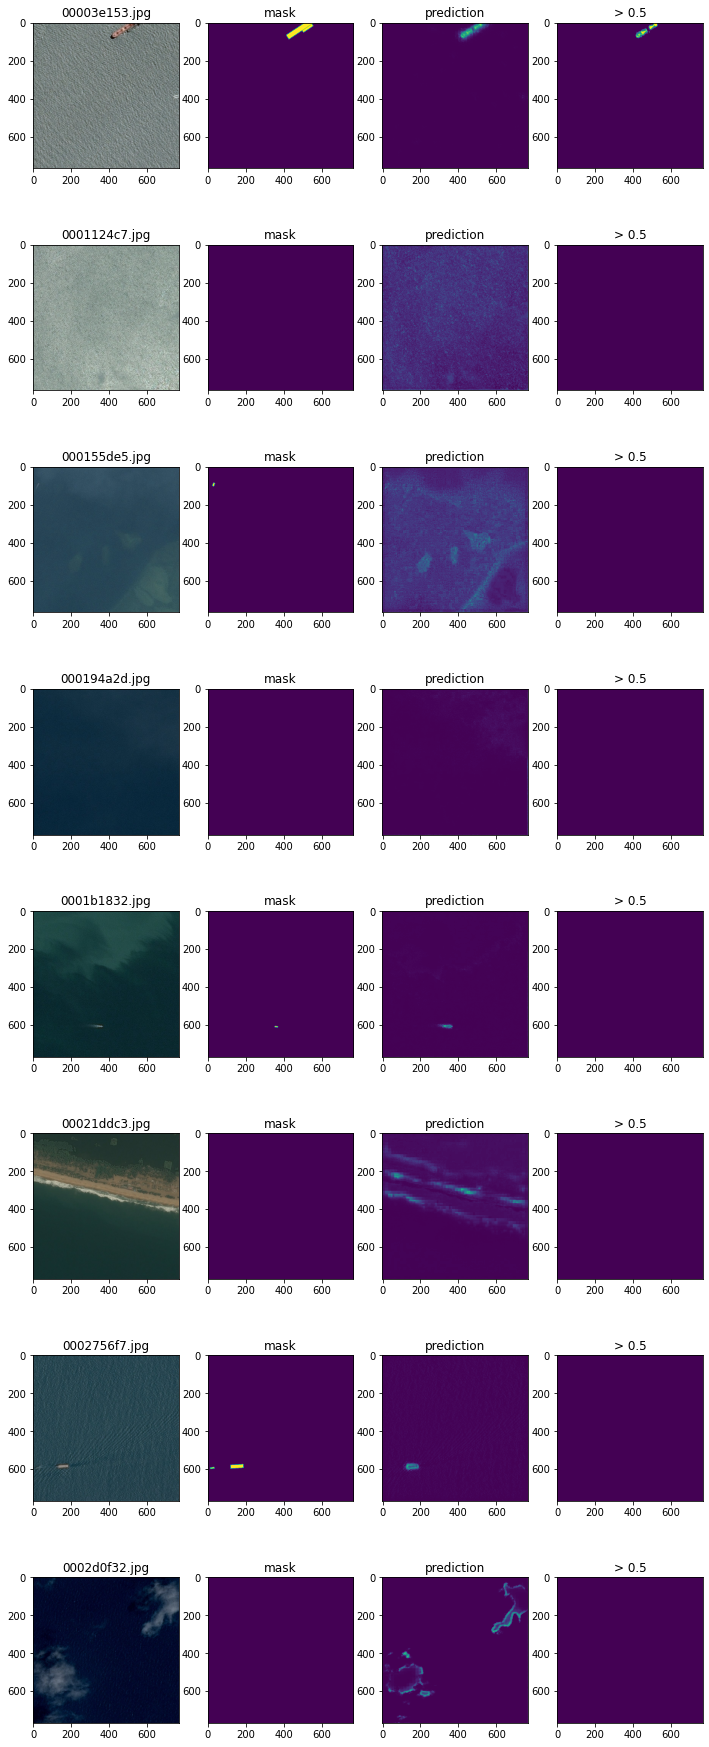

In [23]:
# all data  results
dataset = AirbusDataset(total, transform=normalize_transform)
dice_ls, equal_ls = dice_and_equal(modelb, dataset, all_eval_idx, 5)
print(f"\ndice loss {1-np.mean(dice_ls)}\nthreshold equal {np.mean(equal_ls)}")
visualize(vis_all_idx, modelb)